In [1]:
import os, sys
from os.path import dirname

root_path = os.path.abspath(os.getcwd())
if not root_path in sys.path: sys.path.insert(0, root_path)
    
print(sys.path)

['D:\\GitWork\\ants_and_bees', 'C:\\opt\\miniconda3\\envs\\py37\\python37.zip', 'C:\\opt\\miniconda3\\envs\\py37\\DLLs', 'C:\\opt\\miniconda3\\envs\\py37\\lib', 'C:\\opt\\miniconda3\\envs\\py37', '', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\win32', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\win32\\lib', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\Pythonwin', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Morpheus\\.ipython']


In [11]:
# If you want to download MNIST data by torchvision function

# your_data_path = ''
# torchvision.datasets.MNIST(your_data_path, train=True, transform=None, target_transform=None, download=True)

In [24]:
# e can use download files to create 'training.pt' and 'test.pt'

import gzip
import pprint
import shutil

RootPath_Code = 'D:\\GitWork\\mnist\\'
RootPath_Data = 'D:\\GitWork\\mnist\\data\\'

Dir_Processed = 'processed'
Dir_Raw = 'raw'

Fname_Train = 'training.pt'
Fname_Test  = 'test.pt'

Resources = [
    "train-images-idx3-ubyte.gz", 
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"
]

path_processed = os.path.join(RootPath_Data, Dir_Processed)
path_raw = os.path.join(RootPath_Data, Dir_Raw)

if not os.path.exists(path_processed): os.makedirs(path_processed)

abspath_trainset = os.path.join(path_processed, Fname_Train)
abspath_testset  = os.path.join(path_processed, Fname_Test)

isTrainDataExist = os.path.exists(abspath_trainset)
isTestDataExist  = os.path.exists(abspath_testset)

print("'{}' exist: {}".format(abspath_trainset, isTrainDataExist))
print("'{}' exist: {}".format(abspath_testset, isTestDataExist))

# If all files exist then return 'True' else 'False'
def isExistAllFiles(path, files, debug=False):
    isExistList = [os.path.exists(os.path.join(path, f)) for f in files]
    if debug: print(isExistList)
    return all(isExistList)
                    
isExistResources = isExistAllFiles(path_raw, Resources)
print(isExistResources)

datafiles = [f.replace('.gz', '') for f in Resources]
isExistDataFiles = isExistAllFiles(path_raw, datafiles)
print(isExistDataFiles)
    
if not isExistDataFiles and isExistResources:
    print('Data files not exist, decompressing...')
    for f in Resources:
        inFile  = os.path.join(path_raw, f)
        outFile = os.path.join(path_raw, f.replace('.gz', ''))
        with gzip.open(inFile, 'r') as f_in, open(outFile, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)      
    print('Data files decompressed')

filelist = [f for f in os.listdir(path_raw)]
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(filelist)

'D:\GitWork\mnist\data\processed\training.pt' exist: False
'D:\GitWork\mnist\data\processed\test.pt' exist: False
True
False
[ 't10k-images-idx3-ubyte',
  't10k-images-idx3-ubyte.gz',
  't10k-labels-idx1-ubyte',
  't10k-labels-idx1-ubyte.gz',
  'train-images-idx3-ubyte',
  'train-images-idx3-ubyte.gz',
  'train-labels-idx1-ubyte',
  'train-labels-idx1-ubyte.gz']


In [28]:
from __future__ import print_function, division  

import codecs
import numpy as np
import time

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def open_maybe_compressed_file(path):
    """Return a file object that possibly decompresses 'path' on the fly.
       Decompression occurs when argument `path` is a string and ends with '.gz' or '.xz'.
    """
    if not isinstance(path, torch._six.string_classes):
        return path
    if path.endswith('.gz'):
        import gzip
        return gzip.open(path, 'rb')
    if path.endswith('.xz'):
        import lzma
        return lzma.open(path, 'rb')
    return open(path, 'rb')

def read_sn3_pascalvincent_tensor(path, strict=True):
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
       Argument may be a filename, compressed filename, or file object.
    """
    # typemap
    if not hasattr(read_sn3_pascalvincent_tensor, 'typemap'):
        read_sn3_pascalvincent_tensor.typemap = {
            8: (torch.uint8, np.uint8, np.uint8),
            9: (torch.int8, np.int8, np.int8),
            11: (torch.int16, np.dtype('>i2'), 'i2'),
            12: (torch.int32, np.dtype('>i4'), 'i4'),
            13: (torch.float32, np.dtype('>f4'), 'f4'),
            14: (torch.float64, np.dtype('>f8'), 'f8')
        }
        
    # read
    with open_maybe_compressed_file(path) as f:
        data = f.read()

    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert nd >= 1 and nd <= 3
    assert ty >= 8 and ty <= 14
    m = read_sn3_pascalvincent_tensor.typemap[ty]
    s = [get_int(data[4 * (i + 1): 4 * (i + 2)]) for i in range(nd)]
    parsed = np.frombuffer(data, dtype=m[1], offset=(4 * (nd + 1)))
    assert parsed.shape[0] == np.prod(s) or not strict
    return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)

def read_image_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 3)
    return x

def read_label_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 1)
    return x.long()


def createProcessedDataFiles(path, inFiles, outFiles):

    training_set = (
        read_image_file(os.path.join(path, inFiles[0])),
        read_label_file(os.path.join(path, inFiles[1]))
    )

    test_set = (
        read_image_file(os.path.join(path, inFiles[2])),
        read_label_file(os.path.join(path, inFiles[3]))
    )
    
    with open(os.path.join(path_processed, outFiles[0]), 'wb') as f:
        torch.save(training_set, f)

    with open(os.path.join(path_processed, outFiles[1]), 'wb') as f:
        torch.save(test_set, f)
    
    return (0)


inFiles  = [f.replace('.gz', '') for f in Resources]
outFiles = [Fname_Train, Fname_Test]
createProcessedDataFiles(path_raw, inFiles, outFiles)

for f in outFiles:
    isExist = os.path.exists(os.path.join(path_processed, f))
    print('{} exist: {}'.format(f, isExist))


training.pt exist: True
test.pt exist: True


torch.Size([60000, 28, 28])
torch.Size([60000])


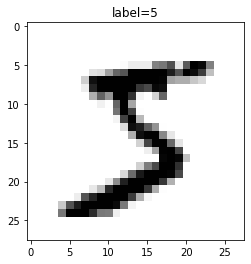

In [43]:
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

normalize = transforms.Normalize((0.1307,), (0.3081,))

transform_train = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# Load entire dataset
train_image, train_label = torch.load(os.path.join(path_processed, Fname_Train))
print(train_image.shape)
print(train_label.shape)

classes = []

class myMnistDataset(Dataset):

    def __init__(self, path, fname):
        abspath_fname = os.path.join(path, fname)
        images, labels = torch.load(abspath_fname)
        self.images = images
        self.labels = labels
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]
        
dataset_train = myMnistDataset(path_processed, Fname_Train)
trainX, trainY = dataset_train[0]

def imgshow(image, label):
    plt.imshow(image.reshape(28,28), cmap='binary')
    plt.title("label = " + str(label))
    plt.show()
    
image = trainX
label = trainY.numpy()
imgshow(image, label)
